In [1]:
import torch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Benchmark functions

Text(0.5, 0.92, 'Six-hump Camelback function used in paper')

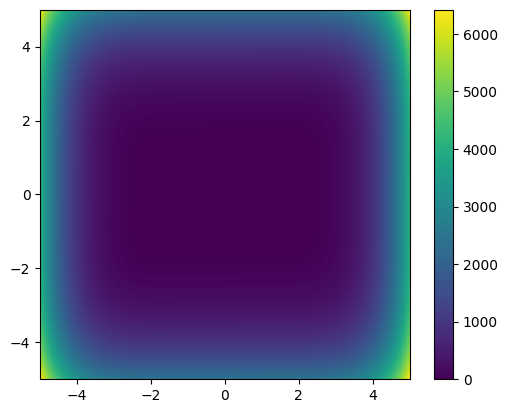

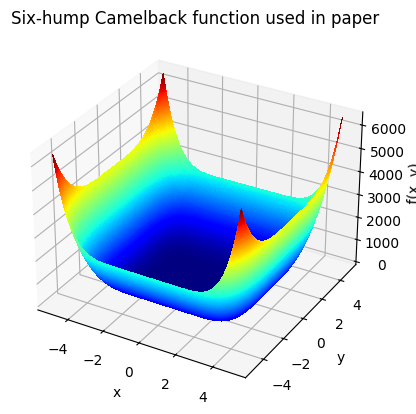

In [6]:
#https://gael-varoquaux.info/scipy-lecture-notes/intro/scipy/auto_examples/plot_2d_minimization.html
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Six Hump Camelback  function
def six_hump(x):
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1]+ (-4 + 4*x[1]**2) * x[1] **2)
# Making grid
x = np.linspace(-5, 5, 400)   # add more points (e.g. 400) for smoother plots
y = np.linspace(-5, 5, 400)
xg, yg = np.meshgrid(x, y)
#Plotting
plt.figure()
plt.imshow(six_hump([xg, yg]), extent=[-5, 5, -5, 5])
plt.colorbar()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xg, yg, six_hump([xg, yg]), rstride=1, cstride=1,cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Six-hump Camelback function used in paper')

Text(0.5, 0.92, 'Six-hump Camelback classic function')

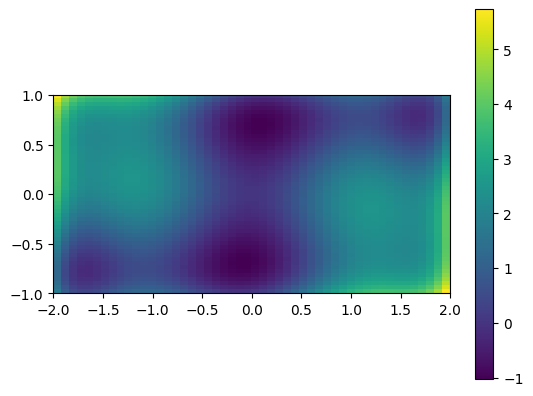

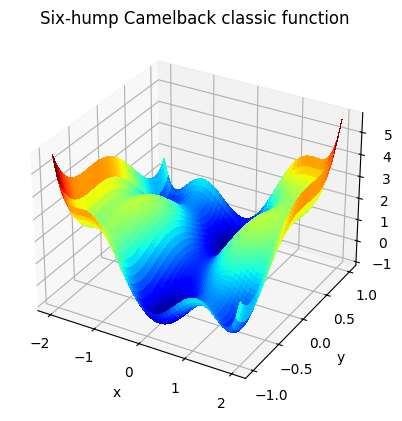

In [8]:
#https://gael-varoquaux.info/scipy-lecture-notes/intro/scipy/auto_examples/plot_2d_minimization.html
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Six Hump Camelback  function
def six_hump_classic(x):
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1]+ (-4 + 4*x[1]**2) * x[1] **2)
# Making grid
x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
xg, yg = np.meshgrid(x, y)
#Plotting
plt.figure()
plt.imshow(six_hump_classic([xg, yg]), extent=[-2, 2, -1, 1])
plt.colorbar()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xg, yg, six_hump_classic([xg, yg]), rstride=1, cstride=1,cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Six-hump Camelback classic function')

## Defining the agents

In [ ]:
import abmax.structs as abx_struct
import abmax.functions as abx_func
import jax.numpy as jnp
import jax.random as random
import jax
from flax import struct
from abmax.structs import *

@struct.dataclass
class Forager(abx_struct.Agent):
    @staticmethod
    def create_agent(type,params: abx_struct.Params | None,id: jnp.int32,active_state: bool,key: jax.random.PRNGKey,):
        """
        Creating a single agent
        """

        # Hyperparamaters
        defaults = {
            'bounds'        : jnp.array([[-3., 3.], [-2., 2.]], dtype=jnp.float32),  # Bounds of where agent can move
            'objective_id'  : 'six_hump',  # id of a function which we want to optimize
        }
        # Allows for extrenal overides, but enables the use of defined hyperparamaters if none are inputed
        incoming = {} if (params is None or not hasattr(params, "content")) else params.content
        hyperparamaters = {**defaults, **incoming}   # set of final Hyperparmaters for the agent

        # Paramaters object and agent carries, agent_params is a dictionary
        agent_params = abx_struct.Params(content=hyperparamaters)
        # Unpacking from dictionary so that I can use them down below
        bounds = hyperparamaters['bounds']
        objective_id = hyperparamaters['objective_id']

        # Random uniform initialization  
        # Gets number of dimensions in the search space
        d = bounds.shape[0] 
        # Each agent gets different key
        key, k0 = random.split(key)
        lo, hi = bounds[:, 0], bounds[:, 1]
        pos = random.uniform(k0, (d,), minval=lo, maxval=hi)

        # Evaluating the agents starting position when initialized
        if objective_id == 'six_hump':
            fit = six_hump(pos).astype(jnp.float32)
        else:
            fit = six_hump_classic(pos).astype(jnp.float32)

        # State 
        state_content = {
            'pos': pos,                                  # current point (real space)
            'fit': fit,                                  # fitnnes
            'best_pos': pos,                             # personal best position
            'best_fit': fit,                             # personal best fitnnes
            'evals': jnp.asarray(1, jnp.int32),          # number of evaluations of the current position the agent has done
        }
        # States which agent carries
        agent_state = abx_struct.State(content=state_content)   
        
        return Forager(params=agent_params,id=id,state=agent_state,agent_type=type,key=key,policy=None,age=jnp.asarray(0.0, jnp.float32),active_state=active_state,)
    
    @staticmethod
    def step_agent(agent, input, step_params):
        def step_inactive_agent():
            return agent
        
        def step_active_agent():
            # Unpacking agent hyperparamaters
            p = agent.params.content
            bounds = p['bounds']
            objective_id = hyperparamaters['objective_id']
            
        

        
        new_agent = jax.lax.cond(agent.active_state, lambda _: step_active_agent(), lambda _: step_inactive_agent(), None)
        return new_agent
    
    
    @staticmethod
    def remove_agent(agents, idx, remove_params):
        agent_to_remove = jax.tree_util.tree_map(lambda x:x[idx], agents)
        new_state_content = {'draw': 0}
        new_state = abx_struct.State(content = new_state_content)
        return agent_to_remove.replace(state = new_state, active_state = False, age = 0.0)
    
    @staticmethod
    def add_agent(agents, idx, add_params):
        agent_to_add = jax.tree_util.tree_map(lambda x:x[idx], agents)
        key, subkey = random.split(agent_to_add.key)
        draw = jax.random.randint(subkey, (1,), 1, 7)
        state_content = {'draw': draw}
        new_state = abx_struct.State(content=state_content)

        return agent_to_add.replace(state = new_state, key = key, active_state = True, age = 0.0)